READ DATA FROM JOHNS HOPKINS GITHUB AND TABULATE IT

In [270]:
import pandas as pd
import numpy as np
##EXTRACT DATA FROM JOHNS HOPKINS GITHUB
#cases and deaths
url_world_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_world_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_us_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_us_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
cases_w = pd.read_csv(url_world_cases, index_col=0)
deaths_w = pd.read_csv(url_world_deaths, index_col=0)
cases_us = pd.read_csv(url_us_cases, index_col=0)
deaths_us = pd.read_csv(url_us_deaths, index_col=0)
#population
url_pop='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
population=pd.read_csv(url_pop, index_col=0).dropna(subset=['Population'])
population=population[population['Admin2'].isnull()]

##CREATE DATAFRAMES WITH DATA (CUMULATIVE CASES AND CUMULATIVE DEATHS)
cum_w=cases_w.groupby('Country/Region').sum().drop(['Lat','Long'],axis=1)
cum_us=cases_us.groupby('Province_State').sum().drop(['code3','FIPS','Lat','Long_'],axis=1)
cum_us.index=cum_us.index+', USA'
cum=cum_w.append(cum_us)
cumd_w=deaths_w.groupby('Country/Region').sum().drop(['Lat','Long'],axis=1)
cumd_us=deaths_us.groupby('Province_State').sum().drop(['code3','FIPS','Lat','Long_','Population'],axis=1)
cumd_us.index=cumd_us.index+', USA'
cumd=cumd_w.append(cumd_us)

#CREATE DATAFRAMES WITH DATA (INDIVIDUAL CASES AND INDIVIDUAL DEATHS)
cases=cum.diff(periods=1, axis=1)
deaths=cumd.diff(periods=1, axis=1)

#CREATE DATAFRAME WITH POPULATION DATA
pop_us=population[population['Country_Region']=='US'].drop(['iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'],axis=1)
pop_us.fillna('USA', inplace=True)
pop_us=pop_us.groupby('Province_State').sum()
pop_us.index=pop_us.index+', USA'
pop_world=population[population['Province_State'].isnull()].drop(['iso2','iso3','code3','FIPS','Admin2','Province_State','Lat','Long_','Combined_Key'],axis=1).set_index('Country_Region')
popul=pop_world.append((pop_us))

#MERGE ALL 4 DATAFRAMES (CUMULATIVE AND INDIVIDUAL CASES AND DEATHS)
dfc=cases.merge(popul, how='inner', left_index=True, right_index=True)
dfc_cum=cum.merge(popul, how='inner', left_index=True, right_index=True)
dfd=deaths.merge(popul, how='inner', left_index=True, right_index=True)
dfd_cum=cumd.merge(popul, how='inner', left_index=True, right_index=True)

#CREATE 7d AVG DATAFRAMES FOR CASES AND DEATHS
dfc7=dfc.iloc[:,0:-1].rolling(7,axis=1).mean()
dfd7=dfd.iloc[:,0:-1].rolling(7,axis=1).mean()

#CREATE NORMALIZED DATAFRAMES FOR CASES AND DEATHS (per 1M HABITANTS, 7d AVG)
cnorm=dfc7.div(dfc.iloc[:,-1], axis=0)*1000000
dnorm=dfd7.div(dfd.iloc[:,-1], axis=0)*1000000

#CREATE CSV FILES
dfc.to_csv('dfc.csv')
dfc_cum.to_csv('dfc_cum.csv')
dfd.to_csv('dfd.csv')
dfd_cum.to_csv('dfd_cum.csv')
dfc7.to_csv('dfc7.csv')
dfd7.to_csv('dfd7.csv')
cnorm.to_csv('cnorm.csv')
dnorm.to_csv('dnorm.csv')

#CREATE SUMMARY TABLE
print(dfc.columns[-2])
summary=pd.DataFrame(data=None)
summary['C7d1M']=cnorm.iloc[:,-1].astype(int)
summary['D7d1M']=round(dnorm.iloc[:,-1],1)
summary['Max_cases']=dfc.iloc[:,0:-1].max(axis=1).astype(int)
summary['Max_deaths']=dfd.iloc[:,0:-1].max(axis=1).astype(int)
summary['Max_c7d1M']=round(cnorm.max(axis=1),1)
summary['Max_d7d1M']=round(dnorm.max(axis=1),1)
summary['Ratio_cases']=round(dfc.iloc[:,-2]/(dfc.iloc[:,0:-2].max(axis=1)),4)
summary['Ratio_deaths']=round(dfd.iloc[:,-2]/(dfd.iloc[:,0:-2].max(axis=1)),4)
summary['Ratio_c7d1M']=round(cnorm.iloc[:,-1]/(cnorm.iloc[:,0:-1].max(axis=1)),4)
summary['Ratio_d7d1M']=round(dnorm.iloc[:,-1]/(dnorm.iloc[:,0:-1].max(axis=1)),4)
summary['%infected']=round(dfc_cum.iloc[:,-2]/dfc_cum.iloc[:,-1]*100,2)
summary['Mortality']=round(cumd.iloc[:,-1]/cum.iloc[:,-1]*1000,0).replace([np.inf,np.nan], 0).astype(int)
summary.to_csv('summary.csv')
#summary[summary['Ratio_d7d1M']>=1].sort_values(by='Ratio_d7d1M', ascending=False)
#summary.sort_values(by='C7d1M',ascending=False).head(20)
#summary.sort_values(by='C7d1M', ascending=False).head(20)

12/18/20


PLOT TABLE WITH TOP-20 ENTITIES IN CASES PER 1M HABITANTS

In [287]:
cnorm

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,4.157823,4.462412,4.693606,4.245897,4.480760,4.411035,4.535807,4.807368,4.862414,5.522968
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,271.487148,276.004488,276.054129,277.692285,275.110948,273.423151,276.203052,270.494326,266.225192,255.204869
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,16.060866,15.155202,14.304921,13.474187,12.542461,12.288354,11.887647,11.379433,10.926601,10.587792
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,591.655804,528.792375,519.547753,523.245602,532.490224,550.979468,471.475719,525.094526,510.303131,523.245602
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,2.108110,2.451493,2.468880,2.716637,2.594932,2.734023,2.751410,2.621011,2.429760,2.177656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Virginia, USA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,412.528267,444.194263,452.863917,459.290843,449.483087,439.825962,428.110213,420.294135,419.256454,417.582775
"Washington, USA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,406.534181,426.495065,468.236576,480.937252,406.290298,368.394633,342.055271,285.849622,281.928734,262.268013
"West Virginia, USA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,682.102847,691.110399,674.769265,683.856530,655.239617,658.906408,689.356717,668.551663,700.675941,726.502904
"Wisconsin, USA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,766.738741,744.779343,715.459254,688.789014,684.274456,684.446205,670.583569,637.484991,626.983737,613.317386


(236,) (236,)


(array([20.,  6., 12., 21., 14., 32., 21., 27., 19.,  9.,  9., 18.,  6.,
         3., 10.,  2.,  0.,  2.,  3.,  2.]),
 array([ 0.  ,  2.35,  4.7 ,  7.05,  9.4 , 11.75, 14.1 , 16.45, 18.8 ,
        21.15, 23.5 , 25.85, 28.2 , 30.55, 32.9 , 35.25, 37.6 , 39.95,
        42.3 , 44.65, 47.  ]),
 <BarContainer object of 20 artists>)

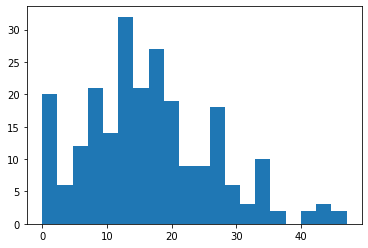

In [281]:
import matplotlib.pyplot as plt
test=summary[summary['Mortality']<50]['Mortality']
print(test.index.shape,test.shape)
plt.hist(test,20)

In [288]:
dateplot=cnorm.columns
cnorm.loc['Oklahoma, USA']

1/22/20            NaN
1/23/20            NaN
1/24/20            NaN
1/25/20            NaN
1/26/20            NaN
               ...    
12/14/20    771.802472
12/15/20    769.166979
12/16/20    802.778547
12/17/20    821.371412
12/18/20    808.952100
Name: Oklahoma, USA, Length: 332, dtype: float64

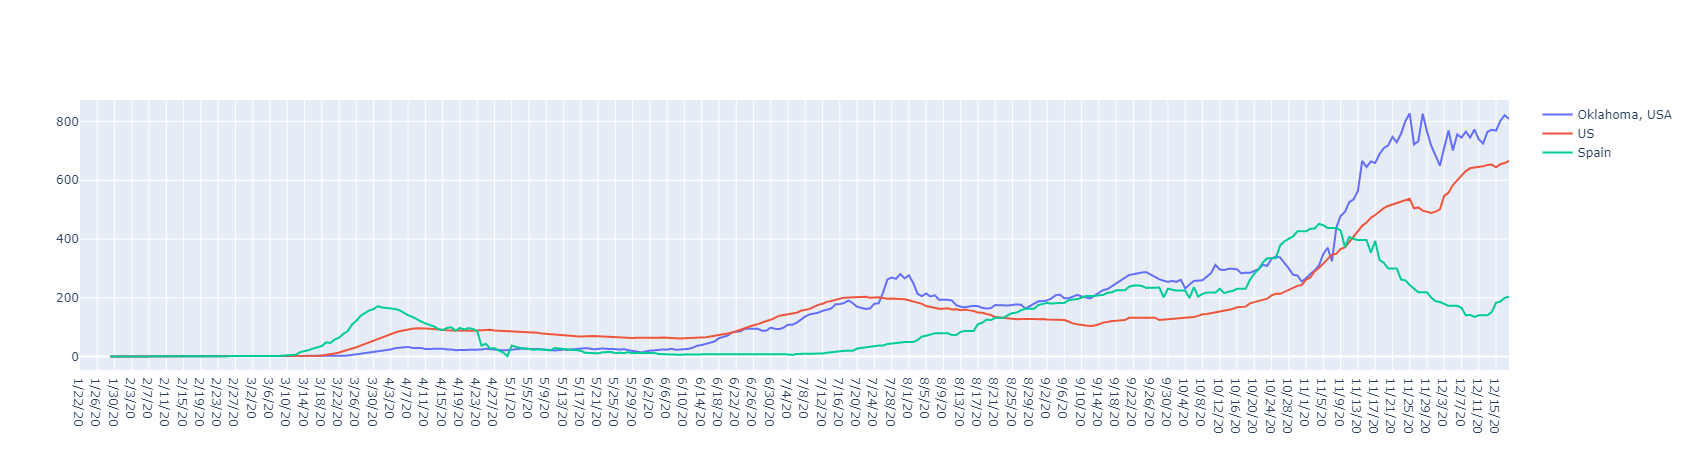

In [295]:
ent1='Oklahoma, USA'
ent2='US'
ent3='Spain'
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=cnorm.columns, y=cnorm.loc[ent1],
                    mode='lines',
                    name=ent1))
fig3.add_trace(go.Scatter(x=cnorm.columns, y=cnorm.loc[ent2],
                    mode='lines',
                    name=ent2))
fig3.add_trace(go.Scatter(x=cnorm.columns, y=cnorm.loc[ent3],
                    mode='lines', name=ent3))
fig3.show()

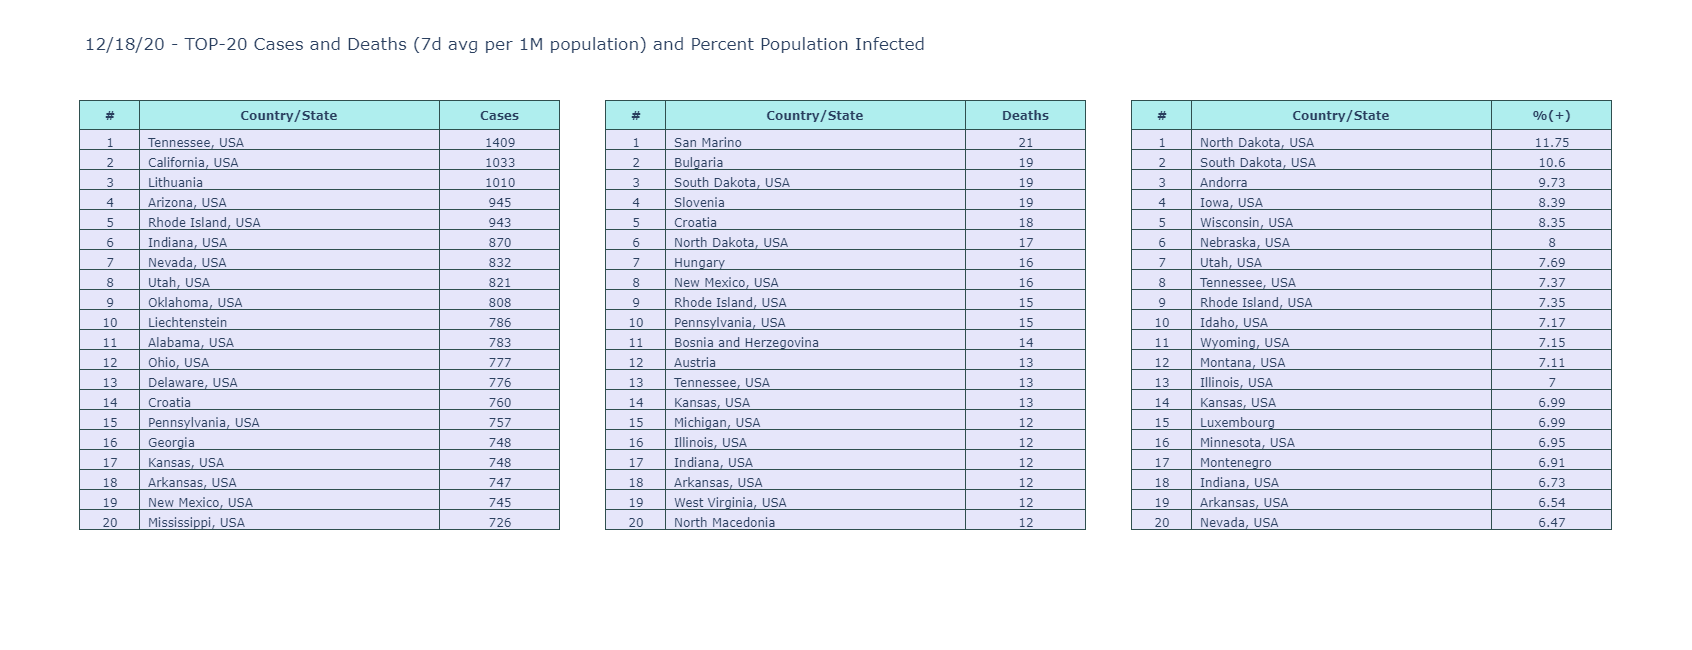

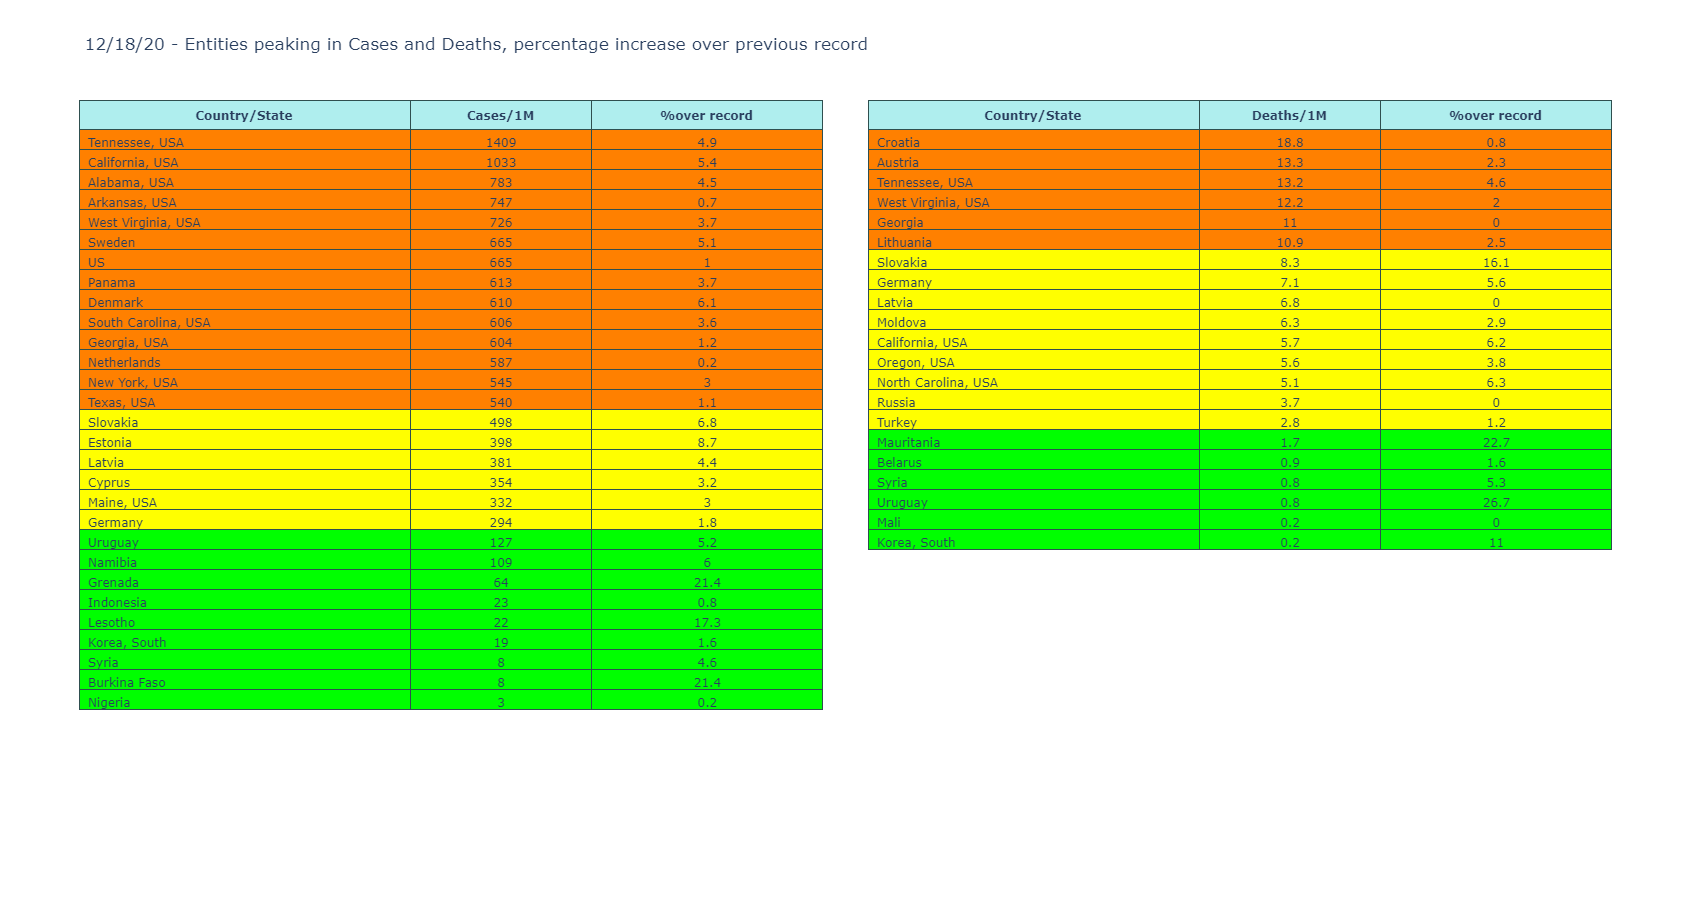

In [205]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

#Create variables
top20c=summary.sort_values(by='C7d1M', ascending=False).head(20)
top20d=summary.sort_values(by='D7d1M', ascending=False).head(20)
top20i=summary.sort_values(by='%infected', ascending=False).head(20)
cpeak=summary[summary['Ratio_c7d1M']>=1].sort_values(by='C7d1M', ascending=False)
dpeak=summary[summary['Ratio_d7d1M']>=1].sort_values(by='D7d1M', ascending=False)
number=np.linspace(1,20,20)


fig1 = make_subplots(rows=1, cols=3,shared_xaxes=False,horizontal_spacing=0.03,specs=[[{"type": "table"},{"type": "table"},{"type": "table"}]])

fig1.add_trace(go.Table(columnorder = [1,2,3], columnwidth = [2,10,4],
    header=dict(values=['<b>#</b>','<b>Country/State</b>', '<b>Cases</b>'],line_color='darkslategray',fill_color='paleturquoise',align='center'),
    cells=dict(values=[number, top20c.index, top20c[top20c.columns[0]].astype(int)],line_color='darkslategray',fill_color='lavender',align=['center','left','center'])),row=1, col=1)

fig1.add_trace(go.Table(columnorder = [1,2,3], columnwidth = [2,10,4],
    header=dict(values=['<b>#</b>','<b>Country/State</b>', '<b>Deaths</b>'],line_color='darkslategray',fill_color='paleturquoise',align='center'),
    cells=dict(values=[number,top20d.index, top20d[top20d.columns[1]].astype(int)],line_color='darkslategray',fill_color='lavender',align=['center','left','center'])),row=1, col=2)

fig1.add_trace(go.Table(columnorder = [1,2,3], columnwidth = [2,10,4],
    header=dict(values=['<b>#</b>','<b>Country/State</b>', '<b>%(+)</b>'],line_color='darkslategray',fill_color='paleturquoise',align='center'),
    cells=dict(values=[number,top20i.index, top20i[top20i.columns[-2]]],line_color='darkslategray',fill_color='lavender',align=['center','left','center'])),row=1, col=3)

fig1.update_layout(height=650,width=1050,showlegend=False,title_text="%s - TOP-20 Cases and Deaths (7d avg per 1M population) and Percent Population Infected" %dfc.columns[-2])

fig1.show()

fig2 = make_subplots(rows=1, cols=2,shared_xaxes=False,horizontal_spacing=0.03,specs=[[{"type": "table"},{"type": "table"}]])

case1M=round(cpeak[cpeak.columns[0]],2)
caseper=round((cpeak[cpeak.columns[-4]]-1)*100,1)

fig2.add_trace(go.Table(columnorder = [1,2,3], columnwidth = [10,5.5,7],
    header=dict(values=['<b>Country/State</b>', '<b>Cases/1M</b>','<b>%over record</b>'],line_color='darkslategray',fill_color='paleturquoise',align='center'),
    cells=dict(values=[cpeak.index, case1M, caseper],fill = dict(color=[['rgba(0, 255, 0, 1)' if val < 150 else 'rgba(255, 255, 0, 1)' if val >=150 and val <500 else 'rgba(255, 128, 0, 1)' for val in case1M]]),line_color='darkslategray',align=['left','center','center'])),row=1, col=1)

death1M=round(dpeak[dpeak.columns[1]],2)
deathper=round((dpeak[dpeak.columns[-3]]-1)*100,1)

fig2.add_trace(go.Table(columnorder = [1,2,3], columnwidth = [10,5.5,7],
    header=dict(values=['<b>Country/State</b>', '<b>Deaths/1M</b>','<b>%over record</b>'],line_color='darkslategray',fill_color='paleturquoise',align='center'),
    cells=dict(values=[dpeak.index, death1M, deathper], fill = dict(color=[['rgba(0, 255, 0, 1)' if val < 2 else 'rgba(255, 255, 0, 1)' if val >=2 and val <10 else 'rgba(255, 128, 0, 1)' for val in death1M]]),line_color='darkslategray',align=['left','center','center'])),row=1, col=2)

fig2.update_layout(height=900,width=950,showlegend=False,title_text=" %s - Entities peaking in Cases and Deaths, percentage increase over previous record" %dfc.columns[-2],)

fig2.show()
#[‘rgb(235,249,39)’ if val >=0.10 and val<= 0.17 else ‘rgb(0,250,0)’ if val <=0.10 else ‘rgb(250,0,0)’ for val in vals